In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8376 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'SugarCane__RedRot',
 'SugarCane____Rust',
 'SugarCane_____Healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch:", labels_batch.numpy())
    print("Class names:", class_names)


Image batch shape: (32, 256, 256, 3)
Labels batch: [1 8 0 6 4 4 5 0 3 6 8 8 1 6 6 6 6 4 7 0 0 4 6 1 6 5 6 8 8 2 6 7]
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'SugarCane__RedRot', 'SugarCane____Rust', 'SugarCane_____Healthy', 'Tomato_Bacterial_spot', 'Tomato_Leaf_Mold', 'Tomato_healthy']


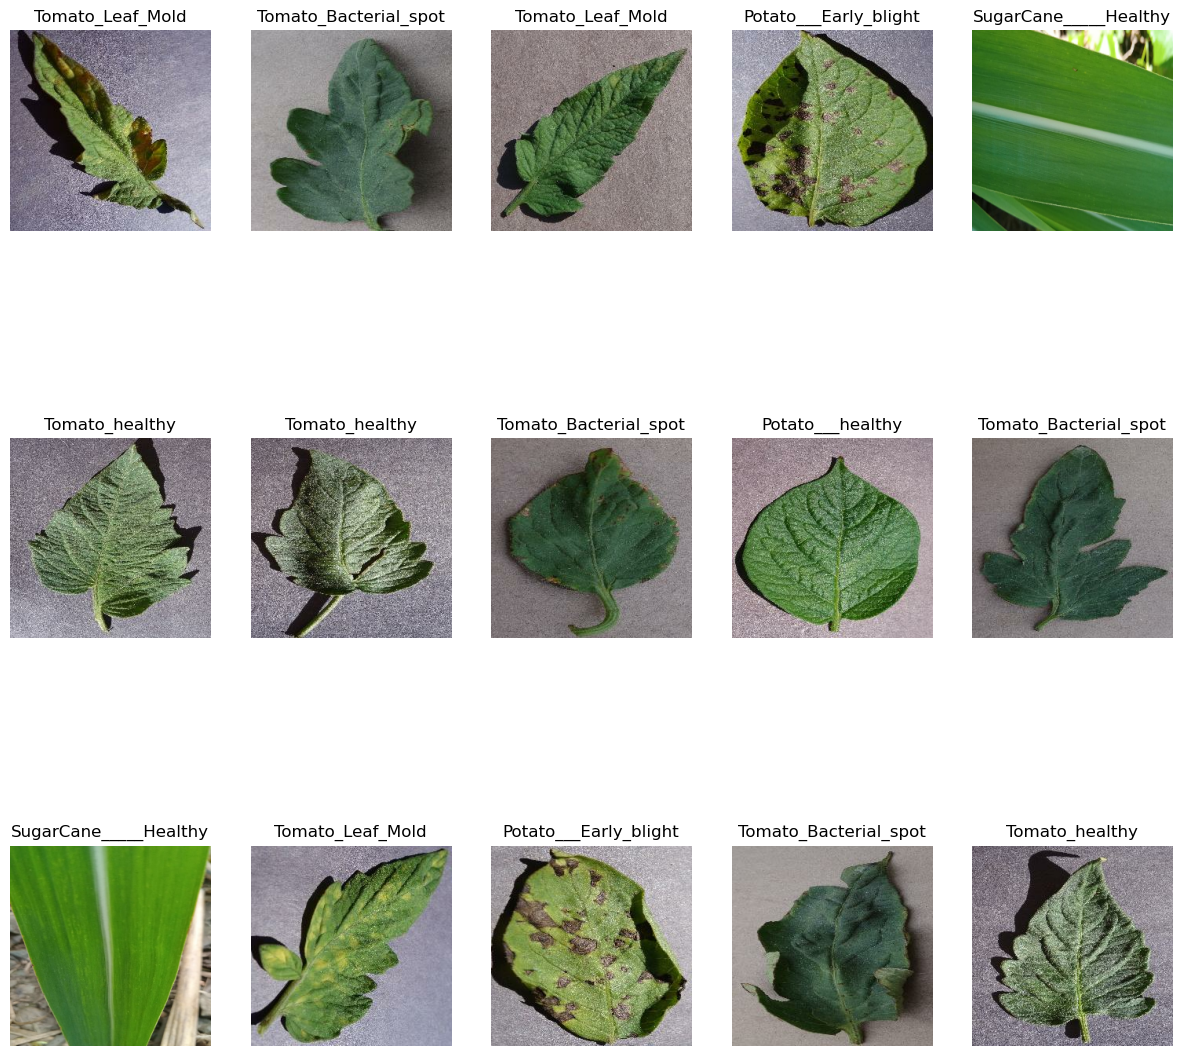

In [6]:
# Function to plot images with labels
def plot_images(images, labels, class_names, max_images=15):
    plt.figure(figsize=(15, 15))
    num_images = min(max_images, len(images))
    for i in range(num_images):
        ax = plt.subplot(3, 5, i + 1)  # Adjust subplot layout if displaying more than 9 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Print a sample of images with labels
for image_batch, labels_batch in dataset.take(1):
    plot_images(image_batch, labels_batch, class_names)
    plt.show()


In [7]:
len(dataset)

262

In [8]:
train_size = 0.8
len(dataset)*train_size

209.60000000000002

In [11]:
train_ds = dataset.take(209)
len(train_ds)

209

In [12]:
test_ds = dataset.skip(209)
len(test_ds)


53

In [13]:
val_size=0.1
len(dataset)*val_size

26.200000000000003

In [14]:
val_ds = test_ds.take(26)
len(val_ds)

26

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

209

In [18]:
len(val_ds)

26

In [19]:
len(test_ds)

26

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Now, build the model
model.build(input_shape=input_shape)

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)        

In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50


209/209 [==============================] - 378s 2s/step - loss: 1.7621 - accuracy: 0.3519 - val_loss: 1.8028 - val_accuracy: 0.4159
Epoch 2/50
209/209 [==============================] - 249s 1s/step - loss: 0.8193 - accuracy: 0.7067 - val_loss: 1.1560 - val_accuracy: 0.6611
Epoch 3/50
209/209 [==============================] - 246s 1s/step - loss: 0.5363 - accuracy: 0.8120 - val_loss: 1.9340 - val_accuracy: 0.5505
Epoch 4/50
209/209 [==============================] - 244s 1s/step - loss: 0.4658 - accuracy: 0.8388 - val_loss: 0.6927 - val_accuracy: 0.7692
Epoch 5/50
209/209 [==============================] - 245s 1s/step - loss: 0.3864 - accuracy: 0.8629 - val_loss: 0.4476 - val_accuracy: 0.8329
Epoch 6/50
209/209 [==============================] - 228s 1s/step - loss: 0.3636 - accuracy: 0.8686 - val_loss: 0.9885 - val_accuracy: 0.7380
Epoch 7/50
209/209 [==============================] - 229s 1s/step - loss: 0.3389 - accuracy: 0.8775 - val_loss: 0.7124 - val_accuracy: 0.79

In [29]:
scores = model.evaluate(test_ds)

26/26 [==============================] - 8s 289ms/step - loss: 0.0803 - accuracy: 0.9794


In [30]:
scores

[0.08030884712934494, 0.9793689250946045]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 209}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

50

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.76211678981781,
 0.8193275332450867,
 0.5363110303878784,
 0.4658363461494446,
 0.3864156901836395]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

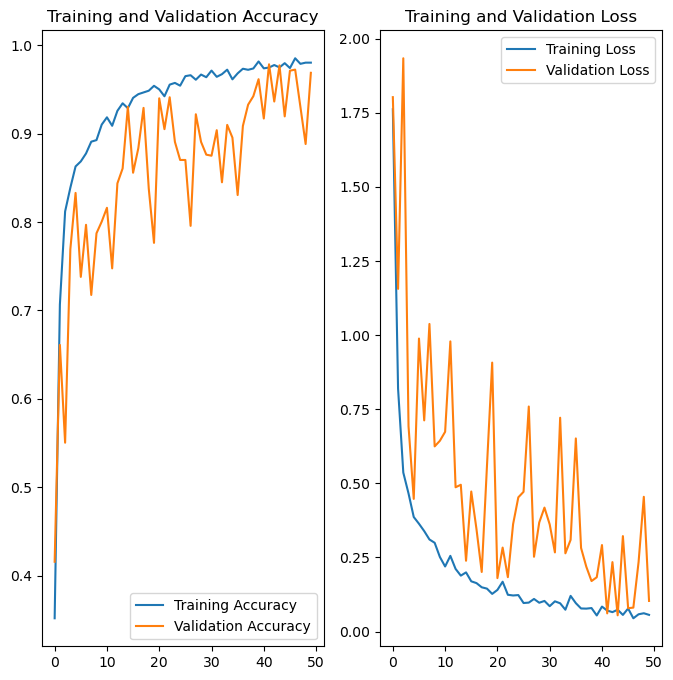

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Tomato_Leaf_Mold
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Leaf_Mold


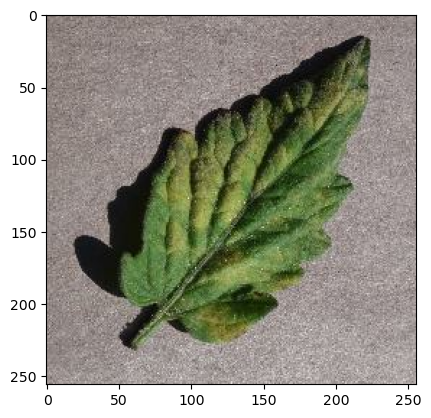

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Expand the dimensions to match the model's input shape
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions on the image
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    
    # Get the predicted class name using the class_names list
    predicted_class = class_names[predicted_class_index]
    
    # Get the confidence level of the prediction
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence


1/1 [==============================] - 0s 27ms/step


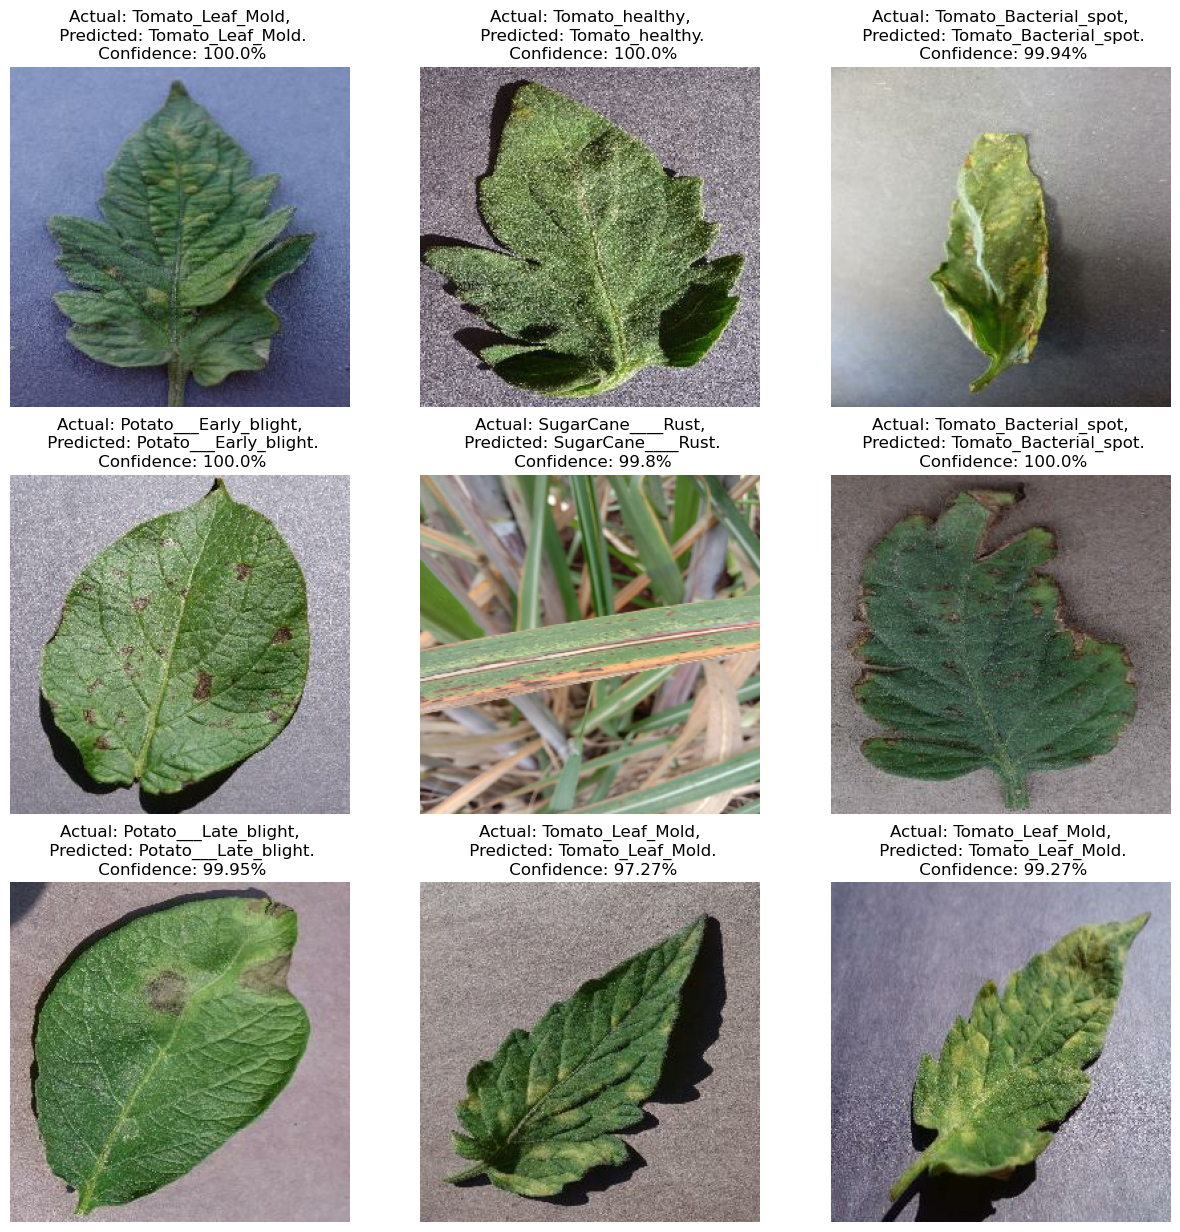

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [43]:
model.save("../potatoes.h5")

E:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
